# Simplifying the Health Insurance Metal Level

### Classification Task 1: Binary Metal Level Classification ('Dental Only' Plans)

### Classification Task 2: Multi-class Metal Level Classification ('Individual' and 'Small Business' Plans)

Metal Levels (Bronze, Silver, Gold, Platinum) were designed to simplify the plan selection process for health insurance customers. By building supervised classification models, we wish to better understand Metal Levels and simplify the method by which Metal Levels are determined. Today, Metal Levels for a particular plan are determined via an Excel Spreadsheet. This method is time consuming and requires skilled labor to enter plan-level properties and values. Once we've determined the most influential features in determining Metal Levels, we can make recommendations to simplify current methods. 

The analysis below imports nationwide plan-level data on plans under the Affordable Care Act. The data is provided by the Centers for Medicaid Services. The data is cleaned, filtered for relevant data, joined, and ultimately modeled via several classification algorithms.

### General Results

Dental Plans:     99% Accuracy given 2 Plan-Level attributes  
Small Business:   95% Accuracy given 5 Plan-Level attributes  
Individual Plans: 90% Accuracy given 10 Plan-Level attributes  

In [1]:
# Import libraries needed for processing and visualizations
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Import and Cleaning

## Attribute Selection from the PlanAttributes.csv

In [2]:
df = pd.read_csv('PlanAttributes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77353 entries, 0 to 77352
Columns: 176 entries, AVCalculatorOutputNumber to WellnessProgramOffered
dtypes: float64(7), int64(9), object(160)
memory usage: 103.9+ MB


As seen below, there are 176 attributes available per plan. Most are 'Object' type or Strings that may be converted to numerical values. There are also many null values in the dataset. A data dictionary is available and helps interpret each attribute. The approach here is to capture as many attributes as possible that may be useful in modeling. We will narrow down the list of attributes in later sections. 

In [3]:
#Data Summary by Column, Null v Not Null Counts
def dataInfo(tmp):
    
    #Data Summary by Column, Null v Not Null Counts
    print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('idx','dtype','  Null', 'Not Null', 'Available','Unique','Column Name'))
    for i, column in enumerate(tmp.columns):
        print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format(i, tmp[column].dtype,
                                                             tmp[column].isnull().sum(), 
                                                             tmp[column].notnull().sum(),
                                                             round(tmp[column].notnull().sum()/tmp[column].shape[0],3),
                                                             tmp[column].unique().shape[0],
                                                              column))
    del tmp

dataInfo(df)

idx dtype              Null   Not Null Available Unique   Column Name
  0 object              22825    54528    0.705     8076 AVCalculatorOutputNumber
  1 int64                   0    77353      1.0        7 BeginPrimaryCareCostSharingAfterNumberOfVisits
  2 int64                   0    77353      1.0        8 BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays
  3 int64                   0    77353      1.0       66 BenefitPackageId
  4 int64                   0    77353      1.0        3 BusinessYear
  5 object                  0    77353      1.0       21 CSRVariationType
  6 object                  0    77353      1.0        4 ChildOnlyOffering
  7 object              76916      437    0.006       67 ChildOnlyPlanId
  8 object              49972    27381    0.354        3 CompositeRatingOffered
  9 object              76425      928    0.012        7 DEHBCombInnOonFamilyMOOP
 10 object              77130      223    0.003        4 DEHBCombInnOonFamilyPerGroupMOOP
 11 object  

From a total of 176 Attributes in the PlanAttributes.csv file, the list of relevant attributes below was put together after referencing the PlansAttributes_DataDictionary.pdf, which describes each attribute's contents and meaning. Attributes that are not included are those containing Product ID's, URLs, redundant columns, import data, and free-text entries. We will focus this project on 2016 health plans. 

In [4]:
relevant = ['AVCalculatorOutputNumber','BeginPrimaryCareCostSharingAfterNumberOfVisits',
              'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays','BusinessYear',
              'ChildOnlyOffering','CompositeRatingOffered','DentalOnlyPlan',
              'EHBPediatricDentalApportionmentQuantity',
              'EHBPercentPremiumS4','EHBPercentTotalPremium','FirstTierUtilization',
              'HSAOrHRAEmployerContribution','HSAOrHRAEmployerContributionAmount',
              'InpatientCopaymentMaximumDays','IsGuaranteedRate','IsHSAEligible',
              'IsNewPlan','IsNoticeRequiredForPregnancy','IsReferralRequiredForSpecialist',
              'IssuerActuarialValue','MarketCoverage','MedicalDrugDeductiblesIntegrated',
              'MedicalDrugMaximumOutofPocketIntegrated',
              'MetalLevel','MultipleInNetworkTiers','NationalNetwork',
              'OutOfCountryCoverage','OutOfServiceAreaCoverage',
              'PlanType','QHPNonQHPTypeId',
              'SecondTierUtilization','StandardComponentId',
              'UniquePlanDesign','WellnessProgramOffered']

df = df[df['BusinessYear'] == 2016]

Additionally, the lists below: coinsurance, individual, family, and summary of benefits (SBC), target attributes that can be grouped into these categories. Organizing into these lists enables us to clean data efficiently in a later step

In [5]:
coinsurance = []
print ('{0:6} {1:20}'.format('Avail%','Column Name'))
for column in df.columns:
    if ('Coinsurance' in column and 'Begin' not in column):
        
        print ('{0:6} {1:20}'.format(round((df[column].notnull().sum()/df[column].shape[0]),3), column))
        
        coinsurance.append(column)

Avail% Column Name         
 0.344 DEHBDedInnTier1Coinsurance
 0.066 DEHBDedInnTier2Coinsurance
 0.344 MEHBDedInnTier1Coinsurance
 0.066 MEHBDedInnTier2Coinsurance
 0.859 SBCHavingDiabetesCoinsurance
 0.859 SBCHavingaBabyCoinsurance
 0.104 SpecialtyDrugMaximumCoinsurance
 0.515 TEHBDedInnTier1Coinsurance
  0.11 TEHBDedInnTier2Coinsurance


In [6]:
individual = []
print ('{0:6} {1:20}'.format('Avail%','Column Name'))
for column in df.columns:
    if ('Individual' in column) and ((df[column].notnull().sum()/df[column].notnull().count()) > 0):
        
        print ('{0:6} {1:20}'.format(round((df[column].notnull().sum()/df[column].shape[0]),3), column))
        
        individual.append(column)

Avail% Column Name         
 0.008 DEHBCombInnOonIndividualMOOP
 0.344 DEHBDedCombInnOonIndividual
 0.344 DEHBDedInnTier1Individual
 0.066 DEHBDedInnTier2Individual
 0.344 DEHBDedOutOfNetIndividual
 0.008 DEHBInnTier1IndividualMOOP
 0.008 DEHBOutOfNetIndividualMOOP
 0.149 MEHBCombInnOonIndividualMOOP
 0.485 MEHBDedCombInnOonIndividual
 0.485 MEHBDedInnTier1Individual
 0.074 MEHBDedInnTier2Individual
 0.485 MEHBDedOutOfNetIndividual
 0.149 MEHBInnTier1IndividualMOOP
 0.008 MEHBInnTier2IndividualMOOP
 0.149 MEHBOutOfNetIndividualMOOP
 0.851 TEHBCombInnOonIndividualMOOP
 0.515 TEHBDedCombInnOonIndividual
 0.515 TEHBDedInnTier1Individual
  0.11 TEHBDedInnTier2Individual
 0.515 TEHBDedOutOfNetIndividual
 0.851 TEHBInnTier1IndividualMOOP
 0.176 TEHBInnTier2IndividualMOOP
 0.851 TEHBOutOfNetIndividualMOOP


In [7]:
family = []
print ('{0:6} {1:20}'.format('Avail%','Column Name'))
for column in df.columns:
    if ('Family' in column) and ((df[column].notnull().sum()/df[column].notnull().count()) > 0):
        
        print ('{0:6} {1:20}'.format(round((df[column].notnull().sum()/df[column].shape[0]),3), column))
        
        family.append(column)

Avail% Column Name         
 0.008 DEHBCombInnOonFamilyPerGroupMOOP
 0.008 DEHBCombInnOonFamilyPerPersonMOOP
 0.344 DEHBDedCombInnOonFamilyPerGroup
 0.344 DEHBDedCombInnOonFamilyPerPerson
 0.344 DEHBDedInnTier1FamilyPerGroup
 0.344 DEHBDedInnTier1FamilyPerPerson
 0.066 DEHBDedInnTier2FamilyPerGroup
 0.066 DEHBDedInnTier2FamilyPerPerson
 0.344 DEHBDedOutOfNetFamilyPerGroup
 0.344 DEHBDedOutOfNetFamilyPerPerson
 0.008 DEHBInnTier1FamilyPerGroupMOOP
 0.008 DEHBInnTier1FamilyPerPersonMOOP
 0.008 DEHBOutOfNetFamilyPerGroupMOOP
 0.008 DEHBOutOfNetFamilyPerPersonMOOP
 0.149 MEHBCombInnOonFamilyPerGroupMOOP
 0.149 MEHBCombInnOonFamilyPerPersonMOOP
 0.485 MEHBDedCombInnOonFamilyPerGroup
 0.485 MEHBDedCombInnOonFamilyPerPerson
 0.485 MEHBDedInnTier1FamilyPerGroup
 0.485 MEHBDedInnTier1FamilyPerPerson
 0.074 MEHBDedInnTier2FamilyPerGroup
 0.074 MEHBDedInnTier2FamilyPerPerson
 0.485 MEHBDedOutOfNetFamilyPerGroup
 0.485 MEHBDedOutOfNetFamilyPerPerson
 0.149 MEHBInnTier1FamilyPerGroupMOOP
 0.149 MEH

In [8]:
SBC = []
print ('{0:6} {1:20}'.format('Avail%','Column Name'))
for column in df.columns:
    if 'SBC' in column and 'Coinsurance' not in column:
        
        print ('{0:6} {1:20}'.format(round((df[column].notnull().sum()/df[column].shape[0]),3), column))
        
        SBC.append(column)

Avail% Column Name         
 0.859 SBCHavingDiabetesCopayment
 0.859 SBCHavingDiabetesDeductible
 0.859 SBCHavingDiabetesLimit
 0.859 SBCHavingaBabyCopayment
 0.859 SBCHavingaBabyDeductible
 0.859 SBCHavingaBabyLimit 


We combine the column/attribute lists above to define our new dataframe without unnecessary columns

In [9]:
df = df[relevant + coinsurance + individual + family + SBC]
df.shape

(27381, 118)

We create the key below to uniquely identify each plan by year

In [10]:
df['key'] = df['BusinessYear'].astype(str) + df['StandardComponentId']

### Attribute Data Cleaning

From the Relevant Attributes List: Attributes in the revelant category are converted from text (object dtypes) to their respective int, float, or binary versions. For example, 64% is converted to 0.64, Yes or No, to 0 and 1 and so on. 

In [11]:
def pConvert(x): #function to convert percentage (%) entries to a value between 0 - 1.
    if float(x) < 1:
        x = float(x)
    elif float(x) == 1:
        x = float(x)
    else:
        x = float(x)/float(100)
    return x

df['AVCalculatorOutputNumber'] = df.AVCalculatorOutputNumber.str.replace('%','')
df['AVCalculatorOutputNumber'] = pd.to_numeric(df.AVCalculatorOutputNumber,errors='raise')
df['AVCalculatorOutputNumber'] = df.AVCalculatorOutputNumber.apply(pConvert)

df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult and Child-only',value=1)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult and Child-Only',value=1)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult-Only',value=0)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Child-Only',value=1)

df['CompositeRatingOffered'] = df.CompositeRatingOffered.replace(to_replace='Yes',value=1)
df['CompositeRatingOffered'] = df.CompositeRatingOffered.replace(to_replace='No',value=0)

df['DentalOnlyPlan'] = df.DentalOnlyPlan.replace(to_replace='Yes',value=1)
df['DentalOnlyPlan'] = df.DentalOnlyPlan.replace(to_replace='No',value=0)

df['EHBPediatricDentalApportionmentQuantity'] = df['EHBPediatricDentalApportionmentQuantity'].replace('[\$,)]','', regex=True).astype(float)

df['FirstTierUtilization'] = df.FirstTierUtilization.str.replace('%','')
df['FirstTierUtilization'] = pd.to_numeric(df.FirstTierUtilization,errors='raise')
df['FirstTierUtilization'] = df.FirstTierUtilization.apply(pConvert)

df['SecondTierUtilization'] = df.SecondTierUtilization.str.replace('%','')
df['SecondTierUtilization'] = pd.to_numeric(df.SecondTierUtilization,errors='raise')
df['SecondTierUtilization'] = df.SecondTierUtilization.apply(pConvert)

df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='NO',value=0)
df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='No',value=0)
df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='Yes',value=1)

df['HSAOrHRAEmployerContributionAmount'] = df['HSAOrHRAEmployerContributionAmount'].replace('[\$,)]','', regex=True).astype(float)

df['IsGuaranteedRate'] = df.IsGuaranteedRate.replace(to_replace='Estimated Rate',value=0)
df['IsGuaranteedRate'] = df.IsGuaranteedRate.replace(to_replace='Guaranteed Rate',value=1)

df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='NO',value=0)
df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='No',value=0)
df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='Yes',value=1)

df['IsNewPlan'] = df.IsNewPlan.replace(to_replace='Existing',value=0)
df['IsNewPlan'] = df.IsNewPlan.replace(to_replace='New',value=1)

df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='NO',value=0)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='No',value=0)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='Yes',value=1)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='yes',value=1)

df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='No',value=0)
df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='Yes',value=1)
df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='yes',value=1)

df['IssuerActuarialValue'] = df.IssuerActuarialValue.str.replace('%','')
df['IssuerActuarialValue'] = pd.to_numeric(df.IssuerActuarialValue,errors='raise')
df['IssuerActuarialValue'] = df.IssuerActuarialValue.apply(pConvert)

df['MarketCoverage'] = df.MarketCoverage.replace(to_replace='Individual',value=0)
df['MarketCoverage'] = df.MarketCoverage.replace(to_replace='SHOP (Small Group)',value=1)

df['MedicalDrugDeductiblesIntegrated'] = df.MedicalDrugDeductiblesIntegrated.replace(to_replace='No', value = 0)
df['MedicalDrugDeductiblesIntegrated'] = df.MedicalDrugDeductiblesIntegrated.replace(to_replace='Yes', value = 1)

df['MedicalDrugMaximumOutofPocketIntegrated'] = df.MedicalDrugMaximumOutofPocketIntegrated.replace(to_replace='No', value = 0)
df['MedicalDrugMaximumOutofPocketIntegrated'] = df.MedicalDrugMaximumOutofPocketIntegrated.replace(to_replace='Yes', value = 1)

df['MultipleInNetworkTiers'] = df.MultipleInNetworkTiers.replace(to_replace='No', value = 0)
df['MultipleInNetworkTiers'] = df.MultipleInNetworkTiers.replace(to_replace='Yes', value = 1)

df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='NO',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='no',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='No',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='YES',value=1)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='YEs',value=1)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='Yes',value=1)

df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='No',value=0)
df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='YES',value=1)
df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='Yes',value=1)

df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='No',value=0)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='YES',value=1)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='Yes',value=1)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='yes',value=1)

df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='No',value=0)
df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='no',value=0)
df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='Yes',value=1)

df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='yes',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Yes',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='no',value=0)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='No',value=0)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Guaranteed Rate',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Estimated Rate',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Allows Adult and Child-Only',value=1)

Cleaning Specific Attribute Categories - as mentioned earlier, each category is now cleaned. Like in the relevant list, entries are converted to their respective numerical values

In [12]:
for col in coinsurance:
    if 'Tier' in col:
        df[col] = df[col].replace(to_replace='$0', value = '0')
        df[col] = df[col].replace(to_replace='$0 ', value = '0')
        df[col] = df[col].str.replace('%','')
        df[col] = pd.to_numeric(df[col],errors='raise')
        df[col] = df[col].apply(pConvert)
    else:
        df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
        df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [13]:
for col in individual:
    df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [14]:
for col in family:
    df[col] = df[col].str.replace(' per group','')
    df[col] = df[col].str.replace(' per person','')
    df[col] = df[col].replace(to_replace='per group not applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per group Not Applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per person not applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per person Not Applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [15]:
for col in SBC:
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

Now we can see that most of the columns are no longer 'Object' type and are now int or float type. 

In [16]:
#Data Summary by Column, Null v Not Null Counts
dataInfo(df)

idx dtype              Null   Not Null Available Unique   Column Name
  0 float64             27381        0      0.0        1 AVCalculatorOutputNumber
  1 int64                   0    27381      1.0        6 BeginPrimaryCareCostSharingAfterNumberOfVisits
  2 int64                   0    27381      1.0        8 BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays
  3 int64                   0    27381      1.0        1 BusinessYear
  4 int64                   0    27381      1.0        2 ChildOnlyOffering
  5 int64                   0    27381      1.0        2 CompositeRatingOffered
  6 int64                   0    27381      1.0        2 DentalOnlyPlan
  7 float64             23526     3855    0.141     1352 EHBPediatricDentalApportionmentQuantity
  8 float64             27381        0      0.0        1 EHBPercentPremiumS4
  9 float64              4271    23110    0.844      453 EHBPercentTotalPremium
 10 float64                 0    27381      1.0       38 FirstTierUtilization
 

We now save this dataframe as df_attr

In [17]:
df_attr = df
del df
print ("Number of unique keys:",df_attr.key.unique().shape)
print ("Shape of df_attr:",df_attr.shape)

Number of unique keys: (8887,)
Shape of df_attr: (27381, 119)


## Prepare Plan-Level Rate data for a Join with the Plan Attributes table

In [18]:
df = pd.read_csv('Rate.csv')

For the Rate.csv, the columns below are relevant for further analysis. Columns that are ignored include data import tags and redundant columns.

In [19]:
ordered_cols = ['BusinessYear','StateCode','IssuerId','PlanId','Tobacco','Age',
                'IndividualRate','IndividualTobaccoRate','PrimarySubscriberAndOneDependent',
                'PrimarySubscriberAndTwoDependents','PrimarySubscriberAndThreeOrMoreDependents',
                'Couple','CoupleAndOneDependent','CoupleAndTwoDependents',
                'CoupleAndThreeOrMoreDependents']

df_rate = df[ordered_cols]
df_rate = df_rate[df_rate['BusinessYear'] == 2016]
df_rate['key'] = df_rate.BusinessYear.astype(str) + df_rate.PlanId

In [20]:
print ("Number of unique keys:",df_rate.key.unique().shape)
print ("Shape of rate data:",df_rate.shape)

Number of unique keys: (8887,)
Shape of rate data: (4221965, 16)


Here, we convert the age to a float value by designating some options to single numeric values. This enables us to use age as an attribute in our models, and since we are building separate models based on the 'Family Option', we can simply filter by Age == 66 or Age != 66.

In [21]:
df_rate['Age'] = df_rate.Age.str.replace('0-20','20')
df_rate['Age'] = df_rate.Age.str.replace('65 and over','65')
df_rate['Age'] = df_rate.Age.replace(to_replace="Family Option", value = '66')
df_rate['Age'] = df_rate.Age.astype(float)

df_rate['Tobacco'] = df_rate.Tobacco.replace(to_replace='No Preference', value = 0)
df_rate['Tobacco'] = df_rate.Tobacco.replace(to_replace='Tobacco User/Non-Tobacco User', value = 1)

In [22]:
df_rate.info() #Checking that our data is in proper data type form before we move forward

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4221965 entries, 8472480 to 12694444
Data columns (total 16 columns):
BusinessYear                                 int64
StateCode                                    object
IssuerId                                     int64
PlanId                                       object
Tobacco                                      int64
Age                                          float64
IndividualRate                               float64
IndividualTobaccoRate                        float64
PrimarySubscriberAndOneDependent             float64
PrimarySubscriberAndTwoDependents            float64
PrimarySubscriberAndThreeOrMoreDependents    float64
Couple                                       float64
CoupleAndOneDependent                        float64
CoupleAndTwoDependents                       float64
CoupleAndThreeOrMoreDependents               float64
key                                          object
dtypes: float64(10), int64(3), object(3)


In [23]:
del df # Free some memory

## Joining the Rate and Attribute Tables

In [24]:
#Pre-join key check
print ("Plan Attribute keys:",df_attr.key.unique().shape)
print ("Rate keys:",df_rate.key.unique().shape)

Plan Attribute keys: (8887,)
Rate keys: (8887,)


In [25]:
df_join_RA = df_rate.merge(df_attr,how='left',on='key') #left, don't want to lose any rate keys

In [26]:
# dropping and renaming redundant rows and columns generated by the join operation
df_join_RA = df_join_RA.drop_duplicates()

if 'BusinessYear_y' in df_join_RA.columns:
    df_join_RA = df_join_RA.drop('BusinessYear_y',axis=1)
    
df_join_RA = df_join_RA.rename(columns={'BusinessYear_x':'BusinessYear'})

In [27]:
#Post-join key check, appears that no keys were lost, which is good
print ('Joined Table key count:',df_join_RA.key.unique().shape)
print ('Joined Table Shape:',df_join_RA.shape)

Joined Table key count: (8887,)
Joined Table Shape: (3990313, 133)


In [28]:
df_join_RA = df_join_RA.reset_index()
df_join_RA = df_join_RA.iloc[:,1:]
df_join_RA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3990313 entries, 0 to 3990312
Columns: 133 entries, BusinessYear to SBCHavingaBabyLimit
dtypes: float64(111), int64(15), object(7)
memory usage: 4.0+ GB


Saving df_join_RA for future use and to skip the steps above

In [29]:
#df_join_RA.to_csv('df_join_RA_2016.csv',encoding='utf-8')

# Modeling Phase

We will now begin the modeling process using the joined dataset from the Rate & Plan Attributes files

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.grid_search import GridSearchCV

In [3]:
def dataInfo(tmp):
    
    #Data Summary by Column, Null v Not Null Counts
    print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('idx','dtype','  Null', 'Not Null', 'Available','Unique','Column Name'))
    for i, column in enumerate(tmp.columns):
        print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format(i, tmp[column].dtype,
                                                             tmp[column].isnull().sum(), 
                                                             tmp[column].notnull().sum(),
                                                             round(tmp[column].notnull().sum()/tmp[column].shape[0],3),
                                                             tmp[column].unique().shape[0],
                                                              column))
    del tmp

#define confusion matrix plotting function
labels = ['Catastrophic','Bronze','Silver','Gold','Platinum']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues,labels=labels):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 16)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize = 14)
    plt.yticks(tick_marks, labels, fontsize = 14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

In [4]:
#reload the joined table into the dataframe (only needed if the kernel is re-started)
df_join_RA = pd.read_csv('df_join_RA_2016.csv')
df_join_RA = df_join_RA.iloc[:,1:]
df_join_RA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3990313 entries, 0 to 3990312
Columns: 133 entries, BusinessYear to SBCHavingaBabyLimit
dtypes: float64(111), int64(15), object(7)
memory usage: 4.0+ GB


# Classification Task 1: Binary Classification - Dental Only Plans

In [5]:
df = df_join_RA

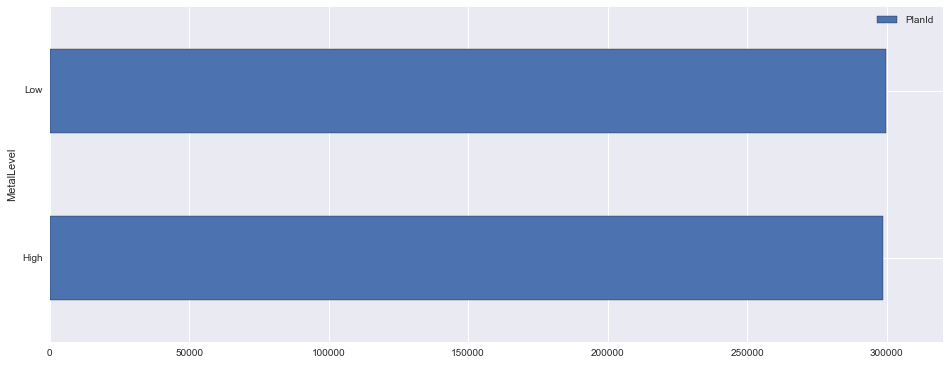

In [6]:
# Filter the data and verify only two levels exist for the Dental Option criteria
tmp = df[df['DentalOnlyPlan'] == 1].groupby('MetalLevel').count().reset_index()
tmp.plot(kind='barh',x ='MetalLevel', y='PlanId', figsize=(16,6))
plt.xlim([0,320000])
plt.show()

Dental Only options contain two Metal Levels: Low and High. They are also equally balanced. 

We will filter our original dataframe by 'DentalOnlyPlan' and inspect the remaining 'object' type attributes to generate one-hot encodings as needed. 

In [7]:
df = df[df['DentalOnlyPlan'] == 1]
df.shape

(598307, 133)

In [8]:
df.groupby('MetalLevel')['key','BusinessYear'].count() #verifying Metal Levels after filter

,key,BusinessYear
MetalLevel,,
High,298733,298733
Low,299574,299574


In [9]:
df.groupby('PlanType')['key','BusinessYear'].count() #Plan Types to require one-hot encoding

,key,BusinessYear
PlanType,,
EPO,13354,13354
HMO,6551,6551
Indemnity,5893,5893
POS,552,552
PPO,571957,571957


In [10]:
#Qualified health plan designation to require one-hot encoding
df.groupby('QHPNonQHPTypeId')['key','BusinessYear'].count() 

,key,BusinessYear
QHPNonQHPTypeId,,
Both,224937,224937
Off the Exchange,311784,311784
On the Exchange,61586,61586


In [11]:
#Generate one-hot encodings
tmp_df = pd.get_dummies(df.PlanType,prefix='PlanType')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.QHPNonQHPTypeId,prefix='QHP')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [12]:
#Renaming a few columns for brevity
df = df.rename(columns = {'BeginPrimaryCareCostSharingAfterNumberOfVisits':'BeginCostSharingAfterNumberOfVisits'})
df = df.rename(columns = {'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays':'BeginDedCoinsAfterNumberOfCopays'})
df = df.rename(columns = {'EHBPediatricDentalApportionmentQuantity':'PediatricDentalApportionmentQty'})
df = df.rename(columns = {'InpatientCopaymentMaximumDays':'InpatientCopayMaxDays'})

As we can see below, very few rows of the entire dataset apply to the 'Dental Only Option'. Given this, we will keep attributes that are 100% complete (contain no Null values) and will create another list of attributes to be imputed given that they at least have 50% of data available. The choice of 50% is a lower bound that the team felt was acceptable for imputing. Generally, we observed poor/biased distributions when we imputed attributes with less than 50% available data.

In [13]:
#Data Summary by Column, Null v Not Null Counts
dataInfo(df)

idx dtype              Null   Not Null Available Unique   Column Name
  0 int64                   0   598307      1.0        1 BusinessYear
  1 object                  0   598307      1.0       38 StateCode
  2 int64                   0   598307      1.0      557 IssuerId
  3 object                  0   598307      1.0     2978 PlanId  
  4 int64                   0   598307      1.0        1 Tobacco 
  5 float64                 0   598307      1.0       47 Age     
  6 float64                 0   598307      1.0     4670 IndividualRate
  7 float64            598307        0      0.0        1 IndividualTobaccoRate
  8 float64            594828     3479    0.006     2435 PrimarySubscriberAndOneDependent
  9 float64            594828     3479    0.006     2608 PrimarySubscriberAndTwoDependents
 10 float64            594828     3479    0.006     2674 PrimarySubscriberAndThreeOrMoreDependents
 11 float64            594828     3479    0.006     2095 Couple  
 12 float64            594828   

List of Attributes with no missing values

In [14]:
#The items in the noNeed list are exceptions that will not be needed in the modeling portion but otherwise qualify
noNeed = ['IssuerId','IssuerActuarialValue']
noNulls = []
for column in df.columns:
    if ((df[column].notnull().sum()/df[column].notnull().count() == 1) and (df[column].dtype != 'object')
       and (column not in noNeed)):
        print ('{0:6} {1:20}'.format(df[column].notnull().sum()/df[column].notnull().count(),column))
        noNulls.append(column)

   1.0 BusinessYear        
   1.0 Tobacco             
   1.0 Age                 
   1.0 IndividualRate      
   1.0 BeginCostSharingAfterNumberOfVisits
   1.0 BeginDedCoinsAfterNumberOfCopays
   1.0 ChildOnlyOffering   
   1.0 CompositeRatingOffered
   1.0 DentalOnlyPlan      
   1.0 PediatricDentalApportionmentQty
   1.0 FirstTierUtilization
   1.0 InpatientCopayMaxDays
   1.0 IsGuaranteedRate    
   1.0 IsNewPlan           
   1.0 MarketCoverage      
   1.0 MultipleInNetworkTiers
   1.0 NationalNetwork     
   1.0 OutOfCountryCoverage
   1.0 OutOfServiceAreaCoverage
   1.0 PlanType_EPO        
   1.0 PlanType_HMO        
   1.0 PlanType_Indemnity  
   1.0 PlanType_POS        
   1.0 PlanType_PPO        
   1.0 QHP_Both            
   1.0 QHP_Off the Exchange
   1.0 QHP_On the Exchange 


List of attributes that may be imputed as more than 50% of data is available. Imputed with medians. 

In [15]:
imputed = []
for column in df.columns:
    if ((column not in noNulls) and (df[column].dtype != 'object') and (column not in noNeed)
       and ( df[column].notnull().sum()/df[column].notnull().count() > 0.5 )):
        print ('{0:6} {1:20}'.format(round(df[column].notnull().sum()/df[column].notnull().count(),4),column))
        imputed.append(column)

0.6142 MEHBDedCombInnOonIndividual
0.5019 MEHBDedInnTier1Individual
0.9439 MEHBInnTier1IndividualMOOP
0.9429 MEHBInnTier1FamilyPerGroupMOOP
 0.938 MEHBInnTier1FamilyPerPersonMOOP


In [16]:
for col in imputed:
    df[col] = df[col].fillna(df[col].median())
    
#Used to perform manually
# df.MEHBDedCombInnOonIndividual = df.MEHBDedCombInnOonIndividual.fillna(df.MEHBDedCombInnOonIndividual.median()) #median
# df.MEHBInnTier1IndividualMOOP = df.MEHBInnTier1IndividualMOOP.fillna(df.MEHBInnTier1IndividualMOOP.median()) #median
# df.MEHBDedCombInnOonFamilyPerPerson = df.MEHBDedCombInnOonFamilyPerPerson.fillna(df.MEHBDedCombInnOonFamilyPerPerson.median()) #median
# df.MEHBInnTier1FamilyPerGroupMOOP = df.MEHBInnTier1FamilyPerGroupMOOP.fillna(df.MEHBInnTier1FamilyPerGroupMOOP.median()) #median
# df.MEHBInnTier1FamilyPerPersonMOOP = df.MEHBInnTier1FamilyPerPersonMOOP.fillna(df.MEHBInnTier1FamilyPerPersonMOOP.median()) #median

The colX list, explanatory variables, contains attribute names that will be used in the models.

In [17]:
colX = noNulls + imputed

Before we model, we will separate our attributes into continuous and categorical feature types. The OneLevel list will capture attributes that only have 1 value and thus offer no value in the modeling process and will thus be excluded from colX

In [18]:
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)
        
colX = continuous + categorical

     1 One Level    int64      BusinessYear        
     1 One Level    int64      Tobacco             
    47 Continuous   float64    Age                 
  4670 Continuous   float64    IndividualRate      
     1 One Level    int64      BeginCostSharingAfterNumberOfVisits
     1 One Level    int64      BeginDedCoinsAfterNumberOfCopays
     1 One Level    int64      ChildOnlyOffering   
     2 Categorical  int64      CompositeRatingOffered
     1 One Level    int64      DentalOnlyPlan      
  1351 Continuous   float64    PediatricDentalApportionmentQty
    17 Continuous   float64    FirstTierUtilization
     1 One Level    int64      InpatientCopayMaxDays
     2 Categorical  float64    IsGuaranteedRate    
     2 Categorical  int64      IsNewPlan           
     2 Categorical  int64      MarketCoverage      
     2 Categorical  int64      MultipleInNetworkTiers
     2 Categorical  int64      NationalNetwork     
     2 Categorical  int64      OutOfCountryCoverage
     2 Categorical  i

## Collinearity Analysis

We will now explore the correlations between attributes. 

(598307, 6)


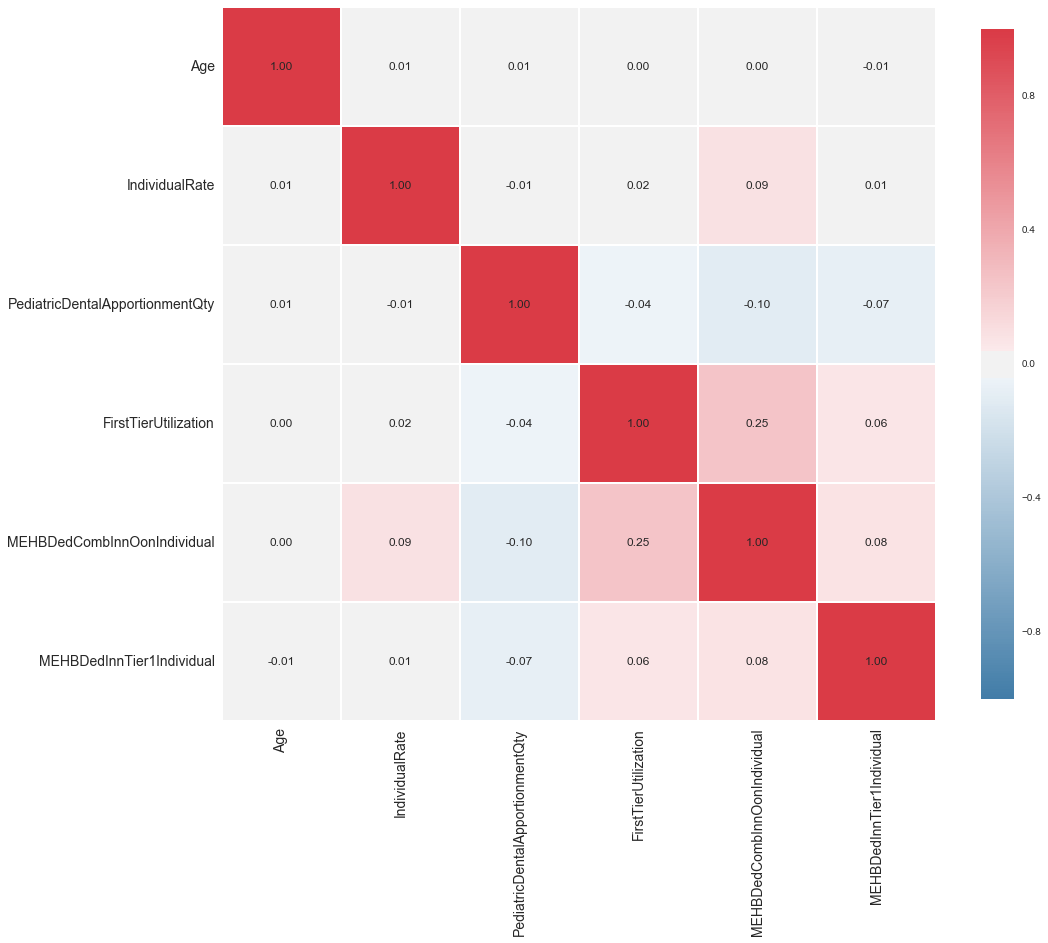

In [19]:
tmp = df[continuous]
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')
plt.yticks(rotation=0, fontsize = 14)
plt.xticks(rotation=90, fontsize = 14)
plt.show()

Based on the correlation matrix above, there is no strong evidence of collinearity.   

The data will now be prepared for modeling. We will begin with a multinomial naive bayes model.  We utilize a 70/30 shufflesplit to randomize our data between the training and test sets, along with 10 iterations for cross-validation.  A seed value of 42 is set to maintain consistency when we compare models.  A Grid Search is utilized to test multiple parameter values for each model. 

Due to computational limitations, we will downsample the entire dataframe via the pandas .sample() method, which randomly selects rows, to expedite the grid search process. Models will be finalized with the entire dataset. 

By default, grid search scoring is based on accuracy unless otherwise specified. In this binary classification case, we believe that accuracy is an adequate comparison measure between models as there is no compelling argument to prioritize recall or precision over accuracy. 

In [20]:
colX = continuous + categorical #Final set of attributes before modeling
print (df[colX].shape)

(598307, 23)


In [21]:
#we randomly downsample to speed up the grid search process
downsample = df.sample(frac=0.2)
print (downsample.shape)

(119661, 141)


### MultinomialNB

In [22]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]} #only viable parameter at this point

In [23]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
gs = GridSearchCV(mnb, parameters, cv=cv, n_jobs=-1, verbose=1)

gs.fit(downsample[colX], downsample['MetalLevel'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.6s finished


GridSearchCV(cv=ShuffleSplit(119661, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [24]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True) #sorted grid scores

[mean: 0.73698, std: 0.00550, params: {'alpha': 10},
 mean: 0.73697, std: 0.00550, params: {'alpha': 0.1},
 mean: 0.73697, std: 0.00550, params: {'alpha': 1},
 mean: 0.73697, std: 0.00551, params: {'alpha': 0.001},
 mean: 0.73697, std: 0.00551, params: {'alpha': 0.01}]

In [25]:
print (gs.best_score_, gs.best_params_) #display best score and parameters

0.736978745926 {'alpha': 10}


The Best MultinomialNB classifier achieved 73% accuracy

### k-Nearest Neighbors

Since the kNN algorithm is computationally intensive, we will lower out k-folds to 3 

In [26]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=3, test_size=0.3, random_state=42)

parameters = {'n_neighbors': [1, 3, 5], #we will focus on odd neighbors to break possible ties
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'minkowski']}

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters, cv=cv, n_jobs=-1, verbose=1)

gs.fit(downsample[colX], downsample['MetalLevel'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.9min finished


GridSearchCV(cv=ShuffleSplit(119661, n_iter=3, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 3, 5], 'metric': ['euclidean', 'minkowski'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [28]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.96948, std: 0.00047, params: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.96948, std: 0.00047, params: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.96948, std: 0.00047, params: {'n_neighbors': 1, 'metric': 'minkowski', 'weights': 'uniform'},
 mean: 0.96948, std: 0.00047, params: {'n_neighbors': 1, 'metric': 'minkowski', 'weights': 'distance'},
 mean: 0.96493, std: 0.00061, params: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.96493, std: 0.00061, params: {'n_neighbors': 3, 'metric': 'minkowski', 'weights': 'distance'},
 mean: 0.96349, std: 0.00111, params: {'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.96349, std: 0.00111, params: {'n_neighbors': 5, 'metric': 'minkowski', 'weights': 'distance'},
 mean: 0.96120, std: 0.00112, params: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.96120, std: 0.00112, params: {'n_neighbors': 3, 'metric': 

In [29]:
print (gs.best_score_, gs.best_params_)

0.969479186978 {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'}


The highest average accuracy of the K Nearest Neighbor model is 96.9%. Not bad, but kNN is computationally taxing. We will continue to evaluate linear and non-linear algorithms. A linear classifier also provides simpler interpretive value.

We will now attempt a Stochastic Gradient Descent model with a 70/30 split and 10 iterations for cross validation. The seed remains at 42.

## SGDClassifier

In [30]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10], 
              'loss':['hinge','log','modified_huber','squared_hinge'], 
              'penalty' : ['l2','l1','elasticnet']}

Before we run the grid search process, we made sure that the continuous variables are the only ones being scaled by the StandardScaler. Once we apply the StandardScaler on the continuous variables, we then concatenate the scaled data with the categorical data and pass it to the GridSearch process. If we had applied the StandardScaler on all the data, the binary categorical attributes would have been shifted and normalized.

In [31]:
sgd = SGDClassifier(n_jobs=-1, class_weight = 'balanced')
gs = GridSearchCV(sgd, parameters, cv=cv)

scl_obj = StandardScaler()
scl_obj.fit(downsample[continuous])

X = scl_obj.transform(downsample[continuous])

X = pd.DataFrame(data = X, index = downsample[continuous].index, columns=continuous)

X = pd.concat([X,downsample[categorical]], axis=1)

gs.fit(X, downsample['MetalLevel'])

GridSearchCV(cv=ShuffleSplit(119661, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'alpha': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [32]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.80266, std: 0.00750, params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.001},
 mean: 0.80214, std: 0.04384, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.001},
 mean: 0.79856, std: 0.01970, params: {'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.001},
 mean: 0.78932, std: 0.01994, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.001},
 mean: 0.78467, std: 0.01413, params: {'penalty': 'l1', 'loss': 'modified_huber', 'alpha': 0.001},
 mean: 0.78429, std: 0.09636, params: {'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.001},
 mean: 0.78161, std: 0.01804, params: {'penalty': 'l1', 'loss': 'modified_huber', 'alpha': 0.01},
 mean: 0.77950, std: 0.09280, params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.01},
 mean: 0.77826, std: 0.01731, params: {'penalty': 'l1', 'loss': 'modified_huber', 'alpha': 0.1},
 mean: 0.77561, std: 0.02429, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.01},
 mean: 0.77451, std: 0.09744, para

In [33]:
print (gs.best_score_, gs.best_params_)

0.802663026825 {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.001}


The highest average accuracy of the SGD model is 80%.

### Random Forests

In [34]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=5, test_size=0.3, random_state=42)

parameters = {'n_estimators': [10,15,20],
              'criterion':['gini','entropy'],
              'max_features':['sqrt','log2']}

In [35]:
rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')
gs = GridSearchCV(rf, parameters, cv=cv, verbose = 1)

gs.fit(downsample[colX], downsample['MetalLevel'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.4min finished


GridSearchCV(cv=ShuffleSplit(119661, n_iter=5, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 'log2'], 'n_estimators': [10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [36]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.99597, std: 0.00023, params: {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 20},
 mean: 0.99593, std: 0.00028, params: {'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 20},
 mean: 0.99590, std: 0.00031, params: {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 20},
 mean: 0.99589, std: 0.00020, params: {'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 15},
 mean: 0.99588, std: 0.00012, params: {'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 20},
 mean: 0.99578, std: 0.00025, params: {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 15},
 mean: 0.99576, std: 0.00018, params: {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 15},
 mean: 0.99574, std: 0.00018, params: {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 10},
 mean: 0.99574, std: 0.00017, params: {'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 15},
 mean: 0.99570, std: 0.00022, params: {'

In [37]:
print (gs.best_score_, gs.best_params_)

0.995966461461 {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 20}


Since we are able to achieve 99.5% accuracy with the Random Forests, we will build a Random Forests model with the entire dataset. We can then explore the most influential variables or feature_importances via Random Forests. A 70/30 train/test split is used to evalute the model with the entire dataset and see it if agrees with the downsampled grid search process.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[colX], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

In [39]:
gsrf_model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'],
                                    criterion = gs.best_params_['criterion'],
                                    max_features = gs.best_params_['max_features'],
                                    class_weight = 'balanced',
                                    n_jobs=-1)

# scores = cross_val_score(gsrf_model, df[colX] , df['MetalLevel'], cv=cv)
# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gsrf_model.fit(X_train,y_train)
yhat = gsrf_model.predict(X_test)

conf = confusion_matrix(y_test,yhat)
acc = accuracy_score(y_test,yhat)

print ('Accuracy:', acc)
print ('Confusion Matrix:\n', conf)

Accuracy: 0.996963669892
Confusion Matrix:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


We will plot the independent variables that have the most influence on our dependent variable.

It is clear from the bat chart below showing feature importances that there are 4 attributes that contriute the most to the Dental Only Metal Level Classification

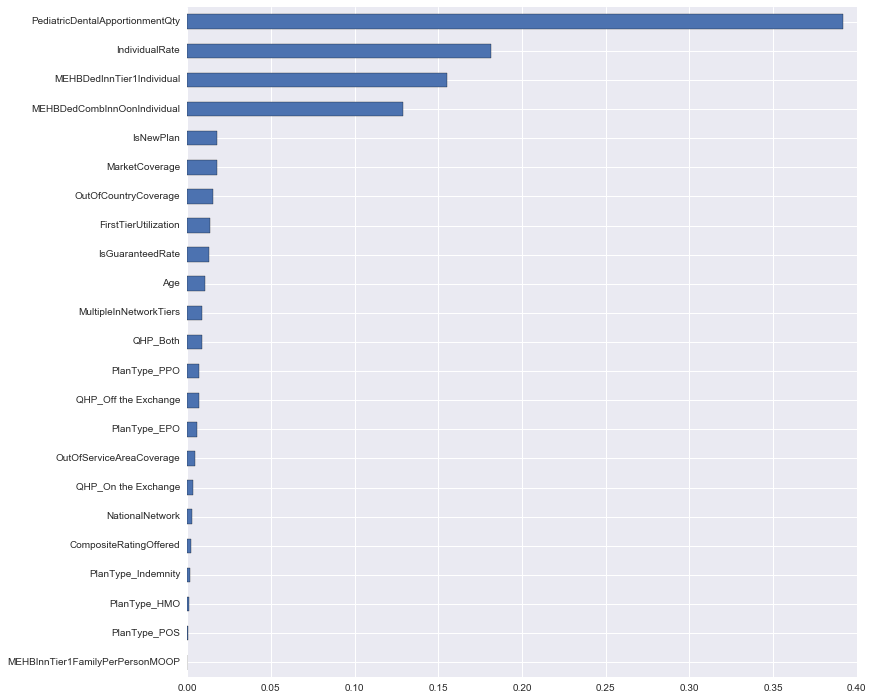

In [40]:
plt.figure(figsize=(12, 12))
weights = pd.Series(gsrf_model.feature_importances_,index=colX)
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')

As it turns out, we only need 2 attributes to achieve accuracies of 99%+. 

In fact, Pediatric Apportionment Qty. can alone achieve over 97%. Below is a quick model showing the accuracies achieved with the 2 attributes. 

In [41]:
reducedSet = ['PediatricDentalApportionmentQty','IndividualRate']

X_train, X_test, y_train, y_test = train_test_split(df[reducedSet], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

simple_model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'],
                                    criterion = gs.best_params_['criterion'],
                                    max_features = gs.best_params_['max_features'],
                                    class_weight = 'balanced',
                                    n_jobs=-1)

# scores = cross_val_score(gsrf_model, df[colX] , df['MetalLevel'], cv=cv)
# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

simple_model.fit(X_train,y_train)
yhat = simple_model.predict(X_test)

conf = confusion_matrix(y_test,yhat)
acc = accuracy_score(y_test,yhat)

print ('Accuracy:', acc)
print ('Confusion Matrix:\n', conf)

Accuracy: 0.994590318285
Confusion Matrix:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Below are a couple of visualizations showing how these 2 varibles distinguish between classes. 

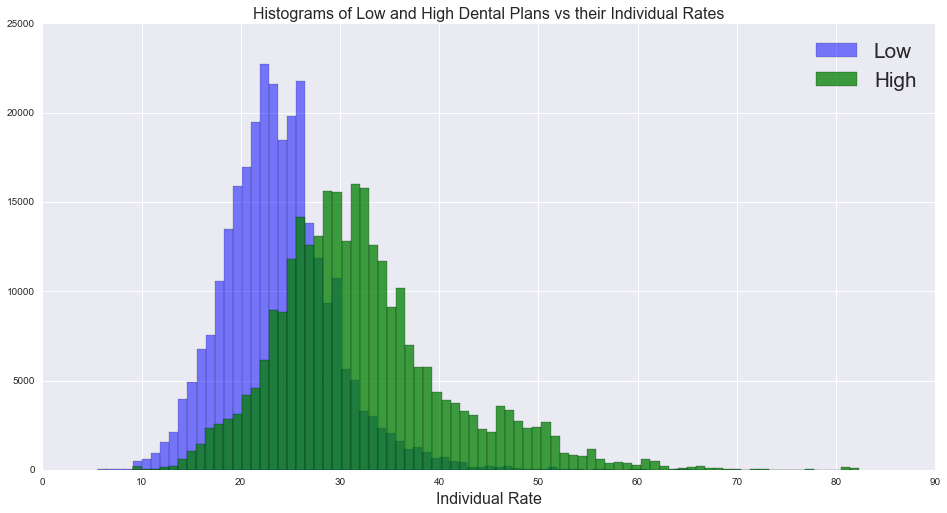

In [42]:
tmp = df[(df.IndividualRate < 90) & (df.IndividualRate > 2)]
col = 'IndividualRate'

tmp1 = tmp.loc[df['MetalLevel'] == 'Low',[col]]
tmp2 = tmp.loc[df['MetalLevel'] == 'High',[col]]

plt.figure(figsize=(16, 8))
plt.hist(tmp1[col], bins=80, alpha = 0.5, label = 'Low', color='b')
plt.hist(tmp2[col], bins=80, alpha = 0.75, label = 'High', color = 'g')

plt.title('Histograms of Low and High Dental Plans vs their Individual Rates', fontsize=16)
plt.xlabel('Individual Rate', fontsize=16)
plt.legend(loc='best',fontsize='xx-large')
plt.show()

Below is a scatterplot Matrix of the two variables. The Target is colored. 

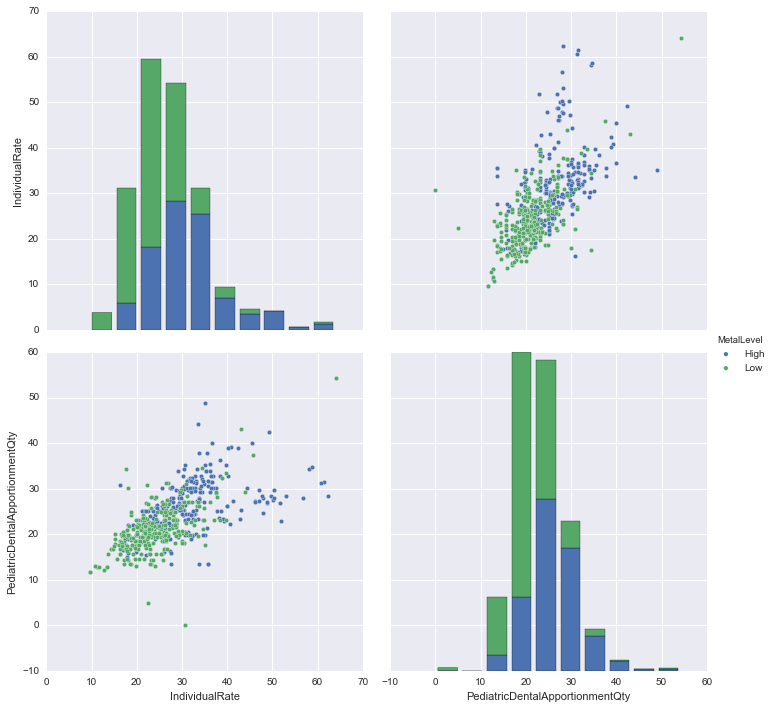

In [43]:
dftmp = tmp[['IndividualRate','PediatricDentalApportionmentQty','MetalLevel']].sample(frac=0.001)

sns.pairplot(dftmp, hue='MetalLevel',size = 5)
plt.show()

## Classification Task 2: Multi-class Classification of Metal Levels

In [44]:
#Resetting dataframe
df = df_join_RA

For the multi-class classification, we will exclude the 'Dental Only Option' from the dataset as we covered this in the previous classification task. There are 5 Metal Levels associated with Individual & Family Health Plans. 

In [45]:
df = df[df['DentalOnlyPlan'] == 0] # Not a Dental Plan Only = 0, DentalOnlyPlan = 1
df = df[df['MarketCoverage'] == 0] # Individual = 0, Small Group (Business) = 1
df = df[df['BusinessYear'] == 2016] #limiting the dataset size to 2016 plans

In [46]:
df.shape

(2397874, 133)

In [47]:
df.groupby('MetalLevel')['key','BusinessYear'].count()

,key,BusinessYear
MetalLevel,,
Bronze,457980,457980
Catastrophic,40296,40296
Gold,306368,306368
Platinum,59478,59478
Silver,1533752,1533752


The attributes below may be one-hot encoded.

In [48]:
df.groupby('PlanType')['key','BusinessYear'].count()

,key,BusinessYear
PlanType,,
EPO,649272,649272
HMO,1006388,1006388
POS,186674,186674
PPO,555540,555540


In [49]:
df.groupby('QHPNonQHPTypeId')['key','BusinessYear'].count()

,key,BusinessYear
QHPNonQHPTypeId,,
Both,2278596,2278596
On the Exchange,119278,119278


In [50]:
tmp_df = pd.get_dummies(df.PlanType,prefix='PlanType')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.QHPNonQHPTypeId,prefix='QHP')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [51]:
#Renaming a few columns for brevity
df = df.rename(columns = {'BeginPrimaryCareCostSharingAfterNumberOfVisits':'BeginCostSharingAfterNumberOfVisits'})
df = df.rename(columns = {'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays':'BeginDedCoinsAfterNumberOfCopays'})
df = df.rename(columns = {'EHBPediatricDentalApportionmentQuantity':'PediatricDentalApportionmentQty'})
df = df.rename(columns = {'InpatientCopaymentMaximumDays':'InpatientCopayMaxDays'})

As we can see in the summary below, a high number of missing values remain. We will move forward with attributes that contain no null values and attributes that have at least 50% of values available. The choice of 50% is a lower bound that the team felt was acceptable for imputing. Generally, we observed poor/biased distributions when we imputed attributes with less than 50% available data.

In [52]:
#Data Summary by Column, Null v Not Null Counts
dataInfo(df)

idx dtype              Null   Not Null Available Unique   Column Name
  0 int64                   0  2397874      1.0        1 BusinessYear
  1 object                  0  2397874      1.0       38 StateCode
  2 int64                   0  2397874      1.0      237 IssuerId
  3 object                  0  2397874      1.0     4058 PlanId  
  4 int64                   0  2397874      1.0        2 Tobacco 
  5 float64                 0  2397874      1.0       46 Age     
  6 float64                 0  2397874      1.0    94059 IndividualRate
  7 float64             60260  2337614    0.975   111105 IndividualTobaccoRate
  8 float64           2397874        0      0.0        1 PrimarySubscriberAndOneDependent
  9 float64           2397874        0      0.0        1 PrimarySubscriberAndTwoDependents
 10 float64           2397874        0      0.0        1 PrimarySubscriberAndThreeOrMoreDependents
 11 float64           2397874        0      0.0        1 Couple  
 12 float64           2397874   

The attributes below have no missing values

In [53]:
noNeed = ['BusinessYear','IssuerId'] #In this case, BusinessYear is added to the list as we are only looking at 2016.
noNulls = []
for column in df.columns:
    if ((df[column].notnull().sum()/df[column].notnull().count() == 1) and (df[column].dtype != 'object')
       and (column not in noNeed)):
        print ('{0:6} {1:20}'.format(df[column].notnull().sum()/df[column].notnull().count(),column))
        noNulls.append(column)

   1.0 Tobacco             
   1.0 Age                 
   1.0 IndividualRate      
   1.0 BeginCostSharingAfterNumberOfVisits
   1.0 BeginDedCoinsAfterNumberOfCopays
   1.0 ChildOnlyOffering   
   1.0 CompositeRatingOffered
   1.0 DentalOnlyPlan      
   1.0 FirstTierUtilization
   1.0 InpatientCopayMaxDays
   1.0 IsHSAEligible       
   1.0 IsNewPlan           
   1.0 IsNoticeRequiredForPregnancy
   1.0 IsReferralRequiredForSpecialist
   1.0 MarketCoverage      
   1.0 MedicalDrugDeductiblesIntegrated
   1.0 MedicalDrugMaximumOutofPocketIntegrated
   1.0 MultipleInNetworkTiers
   1.0 NationalNetwork     
   1.0 OutOfCountryCoverage
   1.0 OutOfServiceAreaCoverage
   1.0 UniquePlanDesign    
   1.0 WellnessProgramOffered
   1.0 SBCHavingDiabetesCoinsurance
   1.0 SBCHavingaBabyCoinsurance
   1.0 SBCHavingDiabetesCopayment
   1.0 SBCHavingDiabetesDeductible
   1.0 SBCHavingDiabetesLimit
   1.0 SBCHavingaBabyCopayment
   1.0 SBCHavingaBabyDeductible
   1.0 SBCHavingaBabyLimit 
   1.0 Pl

The following 5 attributes have at least 50% of their data available and will thus be imputed with their medians

In [54]:
imputed = []
for column in df.columns:
    if ((column not in noNulls) and (df[column].dtype != 'object') and (column not in noNeed)
       and ( df[column].notnull().sum()/df[column].notnull().count() > 0.5 )):
        print ('{0:6} {1:20}'.format(round(df[column].notnull().sum()/df[column].notnull().count(),4),column))
        imputed.append(column)

0.9749 IndividualTobaccoRate
0.9972 EHBPercentTotalPremium
0.6412 TEHBDedInnTier1Coinsurance
  0.64 TEHBDedInnTier1Individual
0.9935 TEHBInnTier1IndividualMOOP
0.6367 TEHBDedInnTier1FamilyPerGroup
0.6197 TEHBDedInnTier1FamilyPerPerson
0.9935 TEHBInnTier1FamilyPerGroupMOOP
0.9933 TEHBInnTier1FamilyPerPersonMOOP


In [55]:
for col in imputed:
    df[col] = df[col].fillna(df[col].median())

In [56]:
# Imputing used to be performed manually
# df.IndividualTobaccoRate = df.IndividualTobaccoRate.fillna(df.IndividualTobaccoRate.median()) #median
# df.EHBPercentTotalPremium = df.EHBPercentTotalPremium.fillna(df.EHBPercentTotalPremium.median()) #median
# df.TEHBDedInnTier1Coinsurance = df.TEHBDedInnTier1Coinsurance.fillna(df.TEHBDedInnTier1Coinsurance.median()) #median
# df.TEHBDedInnTier1Individual = df.TEHBDedInnTier1Individual.fillna(df.TEHBDedInnTier1Individual.median()) #median
# df.TEHBDedInnTier1FamilyPerGroup = df.TEHBDedInnTier1FamilyPerGroup.fillna(df.TEHBDedInnTier1FamilyPerGroup.median()) #median
# df.TEHBDedInnTier1FamilyPerPerson = df.TEHBDedInnTier1FamilyPerPerson.fillna(df.TEHBDedInnTier1FamilyPerPerson.median()) #median

We now have a preliminary list, colX, of attributes to build a supervised classification model.

In [57]:
colX = noNulls + imputed

We will inspect attributes to define them as continuous, categorical, or oneLevel by looking at the number of distinct values that appear in the attribute. oneLevel attributes will not move forward in the analysis as they offer no information in the classification process. 

In [58]:
#establish arrays for continuous, one level and categorical variables
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)

     2 Categorical  int64      Tobacco             
    46 Continuous   float64    Age                 
 94059 Continuous   float64    IndividualRate      
     6 Continuous   int64      BeginCostSharingAfterNumberOfVisits
     8 Continuous   int64      BeginDedCoinsAfterNumberOfCopays
     2 Categorical  int64      ChildOnlyOffering   
     2 Categorical  int64      CompositeRatingOffered
     1 One Level    int64      DentalOnlyPlan      
    23 Continuous   float64    FirstTierUtilization
     6 Continuous   int64      InpatientCopayMaxDays
     2 Categorical  float64    IsHSAEligible       
     2 Categorical  int64      IsNewPlan           
     2 Categorical  float64    IsNoticeRequiredForPregnancy
     2 Categorical  float64    IsReferralRequiredForSpecialist
     1 One Level    int64      MarketCoverage      
     2 Categorical  float64    MedicalDrugDeductiblesIntegrated
     2 Categorical  float64    MedicalDrugMaximumOutofPocketIntegrated
     2 Categorical  int64      Multi

In [59]:
#adding the columns that will be used for analysis
#these are the independent variables
#this excludes the One Level variables
colX = continuous + categorical

### Attribute Analysis - Collinearity

(23979, 23)


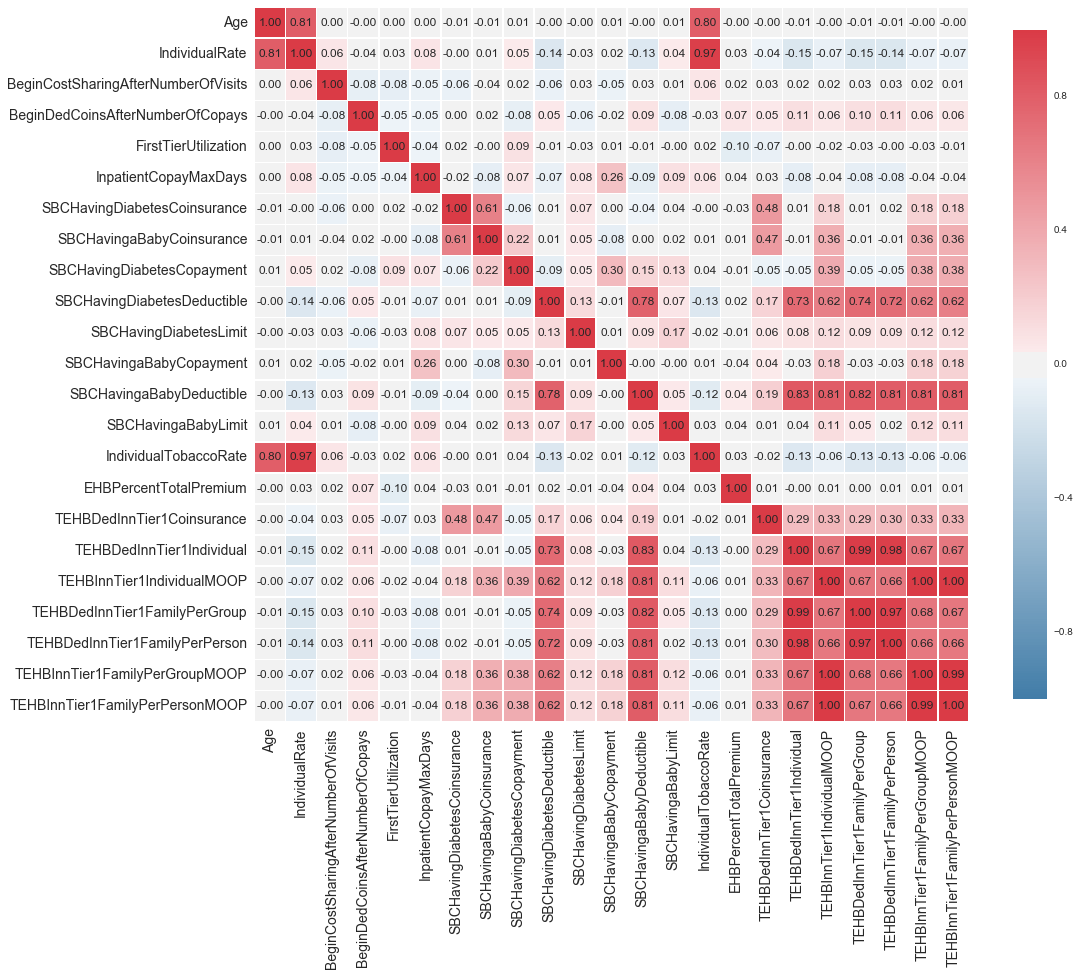

In [60]:
tmp = df[continuous].sample(frac=0.01) #sampled 0.5% to save time in drawing correlation matrix
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')
plt.yticks(rotation=0, fontsize = 14)
plt.xticks(rotation=90, fontsize = 14)
plt.show()

The above correlation matrix shows a large amount of collinearity between a couple of the attributes, 97%+ Pearson's Correlation. Five attributes will be removed for modeling as they appear to be redundant. The attributes are listed below. 

We will create a temporary array for the attributes that we wish to keep in the model by removing attributes showed the highest collinearity.  We will then repeat the process of creating arrays for the continuous and categorical variables (An update). 

In [61]:
collinear = ['TEHBInnTier1FamilyPerGroupMOOP','TEHBInnTier1FamilyPerPersonMOOP',
             'TEHBDedInnTier1FamilyPerGroup','TEHBDedInnTier1FamilyPerPerson',
             'IndividualTobaccoRate']

tmp = []
for col in colX:
    if col not in collinear:
        tmp.append(col)
        
colX = tmp

In [62]:
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)

    46 Continuous   float64    Age                 
 94059 Continuous   float64    IndividualRate      
     6 Continuous   int64      BeginCostSharingAfterNumberOfVisits
     8 Continuous   int64      BeginDedCoinsAfterNumberOfCopays
    23 Continuous   float64    FirstTierUtilization
     6 Continuous   int64      InpatientCopayMaxDays
   220 Continuous   float64    SBCHavingDiabetesCoinsurance
   430 Continuous   float64    SBCHavingaBabyCoinsurance
   253 Continuous   float64    SBCHavingDiabetesCopayment
   223 Continuous   float64    SBCHavingDiabetesDeductible
    18 Continuous   float64    SBCHavingDiabetesLimit
   174 Continuous   float64    SBCHavingaBabyCopayment
   228 Continuous   float64    SBCHavingaBabyDeductible
    12 Continuous   float64    SBCHavingaBabyLimit 
   342 Continuous   float64    EHBPercentTotalPremium
    15 Continuous   float64    TEHBDedInnTier1Coinsurance
   150 Continuous   float64    TEHBDedInnTier1Individual
   145 Continuous   float64    TEHBInnTi

(23979, 18)


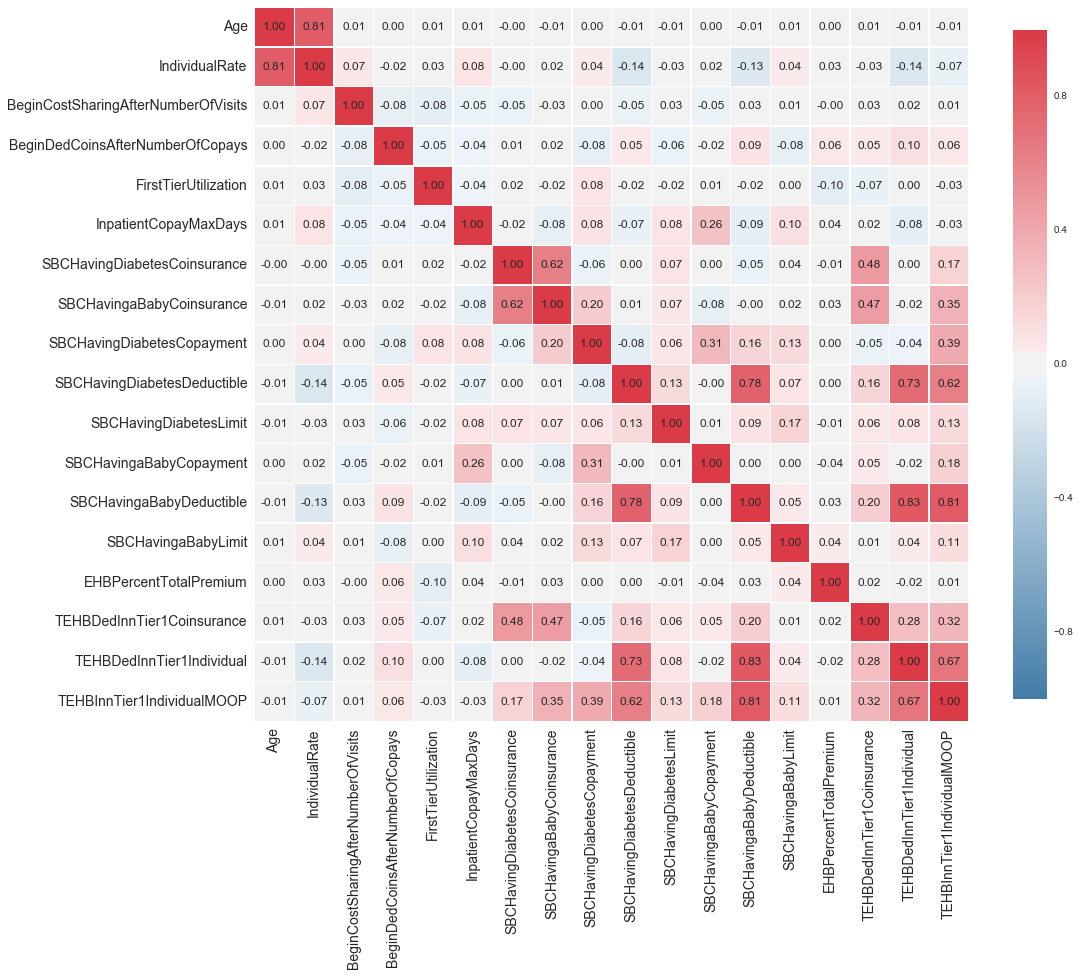

In [63]:
tmp = df[continuous].sample(frac=0.01)
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')
plt.yticks(rotation=0, fontsize = 14)
plt.xticks(rotation=90, fontsize = 14)
plt.show()

Based on the updated correlation matrix, we have reduced the collinearity by removing specific attributes. We are now ready to begin building models with these updated set of attributes.

In [64]:
colX = continuous + categorical
print ('Attributes:', len(colX))

Attributes: 39


To speed up the grid search process, we randomly sampled 1% (23,979 data points) of the available data. This will assist us in finding optimal model parameters. Once the parameters are determined, we will build models using the entire dataset.

In [65]:
#we randomly downsample to speed up the grid search process
downsample = df.sample(frac=0.01)
print (downsample.shape)

(23979, 139)


### Perform GridSearch for SGDClassifier

In [66]:
cv = ShuffleSplit(n = len(downsample), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.001, 0.01, 0.1, 1], 
              'loss':['hinge','log','modified_huber','squared_hinge'], 
              'penalty' : ['l2','l1','elasticnet']}

Before we run the grid search process, we made sure that the continuous variables are the only ones being scaled by the StandardScaler. Once we apply the StandardScaler on the continuous variables, we then concatenate the scaled data with the categorical data and pass it to the GridSearch process. If we had applied the StandardScaler on all the data, the binary categorical attributes would have been shifted and normalized.

In [67]:
sgd = SGDClassifier(n_jobs=-1, class_weight='balanced')
gs = GridSearchCV(sgd, parameters, cv=cv, verbose = 1)

scl_obj = StandardScaler()
scl_obj.fit(downsample[continuous])

X = scl_obj.transform(downsample[continuous])

X = pd.DataFrame(data = X, index = downsample[continuous].index, columns=continuous)

X = pd.concat([X,downsample[categorical]], axis=1)

gs.fit(X, downsample['MetalLevel'])

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   43.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.8min finished


GridSearchCV(cv=ShuffleSplit(23979, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'alpha': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [68]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True) #sorted grid scores

[mean: 0.69594, std: 0.01001, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.001},
 mean: 0.69331, std: 0.00519, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.01},
 mean: 0.69319, std: 0.00563, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.01},
 mean: 0.69027, std: 0.01959, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.001},
 mean: 0.68710, std: 0.01303, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.001},
 mean: 0.68236, std: 0.00880, params: {'penalty': 'l2', 'loss': 'modified_huber', 'alpha': 0.1},
 mean: 0.67987, std: 0.00269, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.1},
 mean: 0.67748, std: 0.01278, params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.01},
 mean: 0.67748, std: 0.00548, params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.1},
 mean: 0.67455, std: 0.02066, params: {'penalty': 'elasticnet', 'loss': 'squared_hinge', 'alpha': 1},
 mean: 0.67430, std: 0.00499, params: {'penalty': 

In [69]:
print (gs.best_score_, gs.best_params_) #best grid score with corresponding parameters

0.695941061996 {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.001}


Let's build an SGD Classifier model with the optimal GridSearch parameters and assess the accuracy score

In this case, we use the entire dataset, not the downsample

In [70]:
scl_obj = StandardScaler()
scl_obj.fit(df[continuous])

X = scl_obj.transform(df[continuous])

X = pd.DataFrame(data = X, index=df[continuous].index, columns=continuous)

X = pd.concat([X, df[categorical]],axis=1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, df['MetalLevel'], 
                                                    test_size=0.30, random_state=42)

gs_sgd = SGDClassifier(alpha=gs.best_params_['alpha'], 
                       loss=gs.best_params_['loss'], 
                       penalty=gs.best_params_['penalty'], 
                       class_weight='balanced')

# scores = cross_val_score(gs_sgd, X, df['MetalLevel'], cv=cv)
# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gs_sgd.fit(X_train, y_train)
yhat = gs_sgd.predict(X_test)

labels = ['Catastrophic','Bronze','Silver','Gold','Platinum']
conf = confusion_matrix(y_test, yhat, labels)
acc = accuracy_score(y_test, yhat)

print (acc)
print (conf)

0.704150755599
[[ 10773   1154      0      4      0]
 [  4349  81425  46212   4283   1059]
 [   478  52084 359375  35862  12275]
 [     0   3027  39213  41244   8656]
 [     0     31   1927   2209  13723]]


A better looking confusion matrix

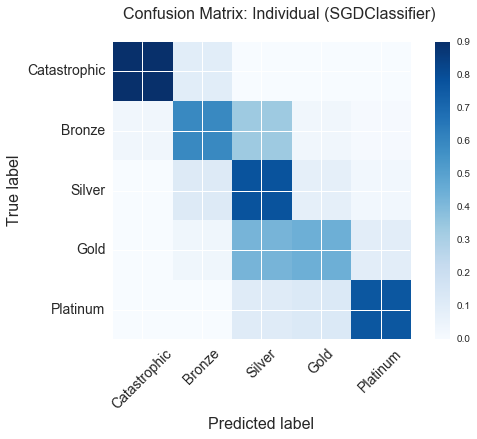

In [72]:
plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Confusion Matrix: Individual (SGDClassifier)\n',
                      labels=labels)

The SGDClassifier generates a set of weights for each class (One-vs-All approach). To determine which attributes are most influential in this model, we normalized each weight set and plotted the weights by attribute for the 5 classes on the same bar plot. Visually there is no clear indication that 1 or a couple of attributes are most important. We also ran a Recursive Feature Elimination (RFE) function on the data but the top 10 features do not seem to reflect what we see visually. It appears that the RFE may only operate on one of the set of weights. 

We will try a random forests classfier next and take a look at its feature importances to see if theres a better relationship. 

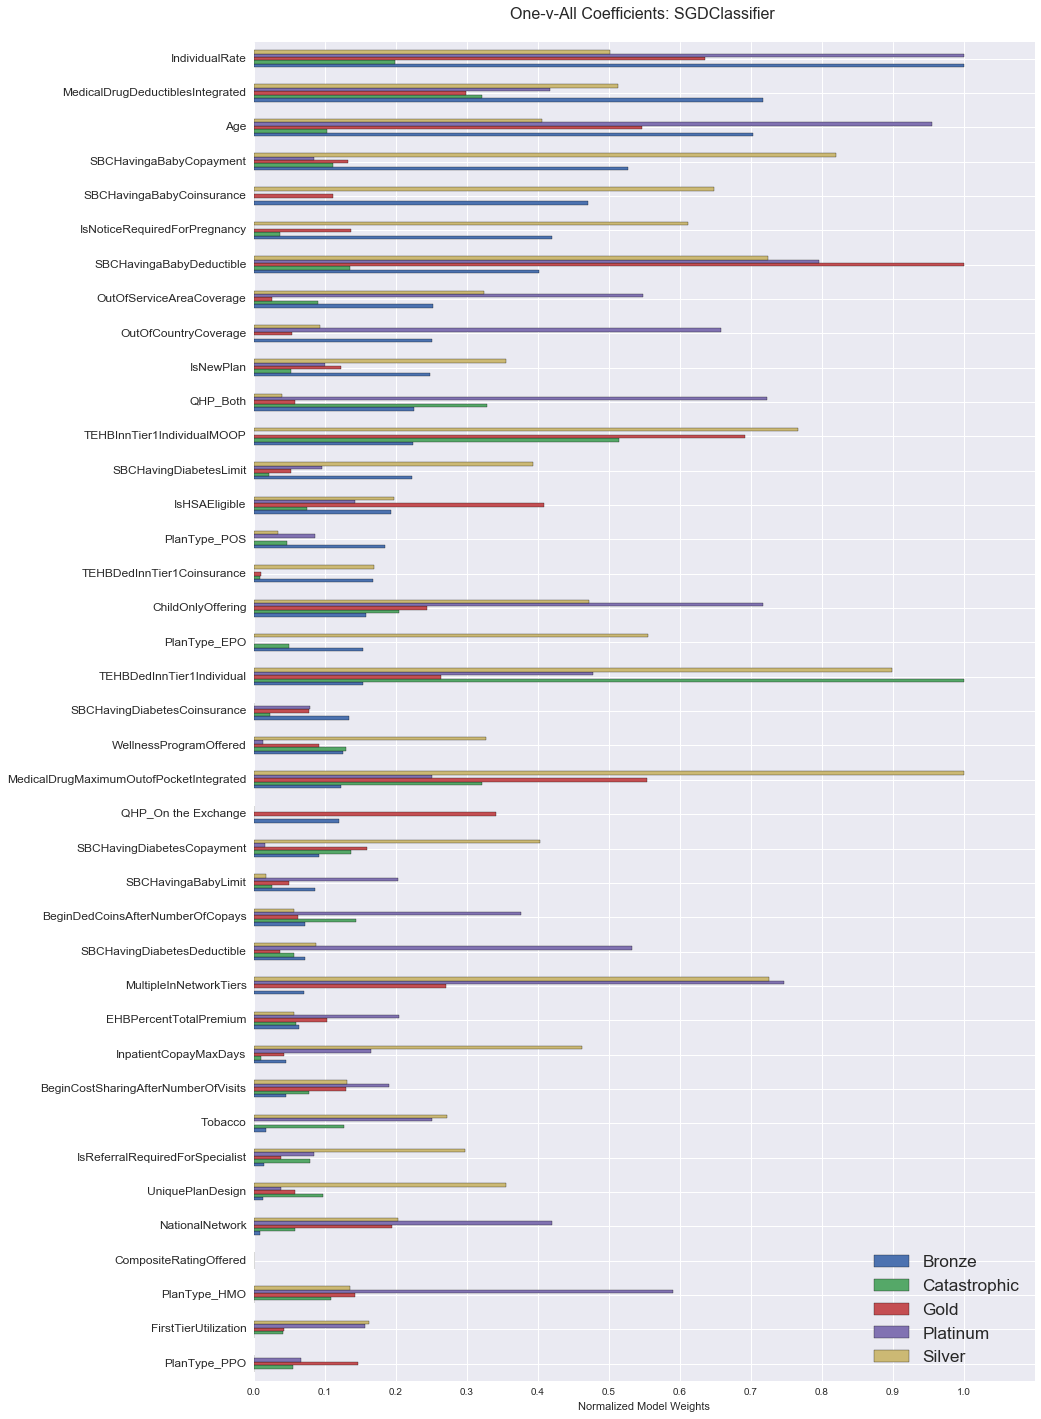

In [73]:
weights = []
for metal in range(0, len(gs_sgd.classes_)):
    weights.append(pd.Series(abs(gs_sgd.coef_[metal]),index=colX))

allWeights = pd.concat(weights,axis=1)

for metal in range(0, len(gs_sgd.classes_)):
    allWeights = allWeights.rename(columns={metal:gs_sgd.classes_[metal]})
    allWeights[gs_sgd.classes_[metal]] = allWeights[gs_sgd.classes_[metal]]/abs(allWeights[gs_sgd.classes_[metal]]).max()

    
allWeights.sort_values('Bronze',ascending=True).plot(kind='barh',stacked=False,figsize=(14,24))

plt.xlim([0,1.1])
plt.xticks(np.arange(0, 1.05, .1))
plt.yticks(fontsize=12)
plt.title('One-v-All Coefficients: SGDClassifier \n', fontsize = 16)
plt.xlabel('Normalized Model Weights')
plt.legend(loc='best', fontsize = 'x-large',)

### SKLearn's Recursive Feature Elimination (RFE) Analysis 

In [74]:
rfe = RFE(estimator=gs_sgd, n_features_to_select=10, step=5, verbose = 1)
rfe.fit(X,df['MetalLevel'])

Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.
Fitting estimator with 19 features.
Fitting estimator with 14 features.


RFE(estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
  estimator_params=None, n_features_to_select=10, step=5, verbose=1)

These features appear to be most associated with either the Platinum or Catastrophic Metal Levels and thus, do not provide a way of determining the overall most influential features. This was an exploratory exercise to test SKLearn's RFE 

In [75]:
features = []
for i in range(0,len(colX)):
    if rfe.support_[i] == True:
        features.append(colX[i])
features

['Age',
 'IndividualRate',
 'SBCHavingDiabetesDeductible',
 'SBCHavingaBabyDeductible',
 'TEHBDedInnTier1Individual',
 'TEHBInnTier1IndividualMOOP',
 'ChildOnlyOffering',
 'MedicalDrugDeductiblesIntegrated',
 'MedicalDrugMaximumOutofPocketIntegrated',
 'QHP_Both']

## Classification with RandomForests

In [76]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'n_estimators': [10,15,20,25],
              'criterion':['gini','entropy'],
              'max_features':['sqrt','log2']}

In [77]:
rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')
gsrf = GridSearchCV(rf, parameters, cv=cv, verbose = 1)

gsrf.fit(downsample[colX], downsample['MetalLevel'])

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   30.8s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.6min finished


GridSearchCV(cv=ShuffleSplit(23979, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 'log2'], 'n_estimators': [10, 15, 20, 25], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [78]:
sorted(gsrf.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.91858, std: 0.00311, params: {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 25},
 mean: 0.91843, std: 0.00189, params: {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 25},
 mean: 0.91825, std: 0.00174, params: {'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 25},
 mean: 0.91807, std: 0.00341, params: {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 20},
 mean: 0.91789, std: 0.00135, params: {'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 20},
 mean: 0.91756, std: 0.00313, params: {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 20},
 mean: 0.91713, std: 0.00271, params: {'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 25},
 mean: 0.91611, std: 0.00313, params: {'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 20},
 mean: 0.91594, std: 0.00207, params: {'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 15},
 mean: 0.91586, std: 0.00366, params: {'

In [79]:
print (gsrf.best_score_, gsrf.best_params_)

0.918584931888 {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 25}


We will now fit a Random Forests model with the entire dataset given the optimal grid search parameters

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df[colX], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

In [81]:
gsrf_model = RandomForestClassifier(n_estimators = gsrf.best_params_['n_estimators'],
                                    criterion = gsrf.best_params_['criterion'],
                                    max_features = gsrf.best_params_['max_features'],
                                    class_weight = 'balanced',
                                    n_jobs=-1)

# scores = cross_val_score(gsrf_model, df[colX] , df['MetalLevel'], cv=cv)
# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gsrf_model.fit(X_train,y_train)
yhat = gsrf_model.predict(X_test)

conf = confusion_matrix(y_test,yhat,labels)
acc = accuracy_score(y_test,yhat)

print (acc)
print (conf)

0.969388194833
[[ 11798    133      0      0      0]
 [   149 132321   4542    316      0]
 [     0   4882 450489   4267    436]
 [     0    375   4490  86314    961]
 [     0      0    491    979  16420]]


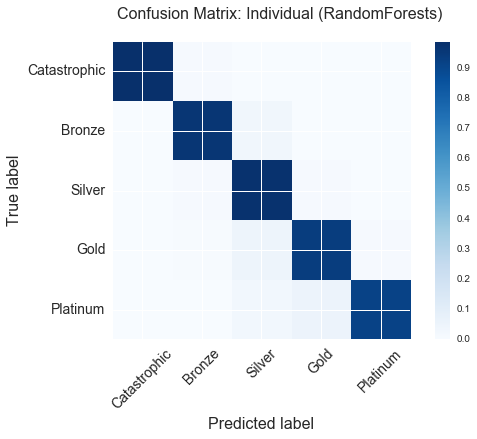

In [82]:
plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Confusion Matrix: Individual (RandomForests)\n',
                      labels=labels)

Given the high accuracy achieved, the bar plot of the feature importances shows that the Maximum out of pocket, deductibles, and individual premium rates are most important in classifying the metal levels. It is interesting to note that most of the categorical variables are not as influential as they appear to be in the linear SGD classifier model. 

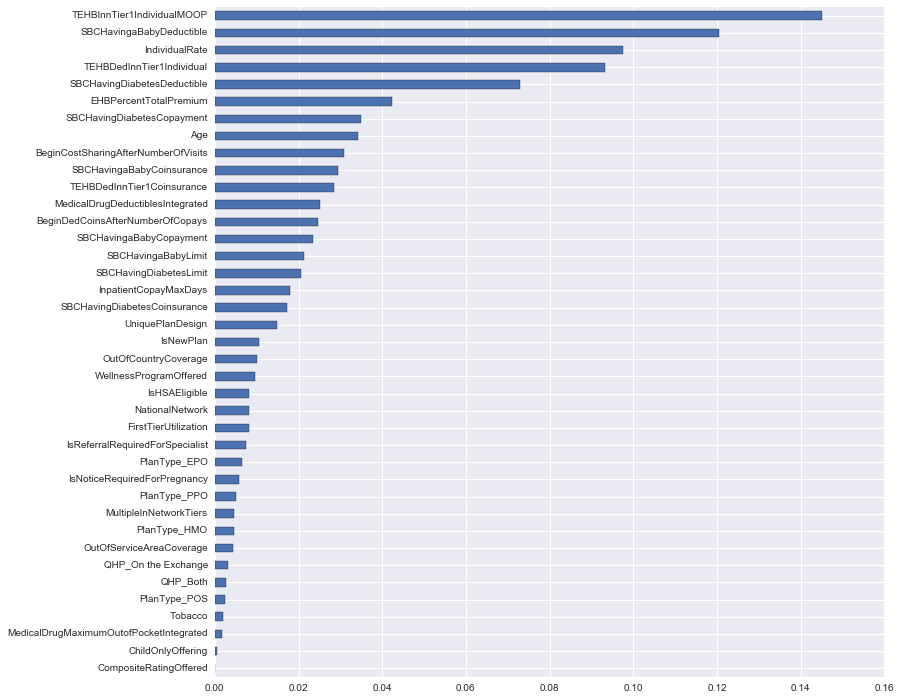

In [83]:
plt.figure(figsize=(12, 12))
weights = pd.Series(gsrf_model.feature_importances_,index=colX)
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')

In running an RFE with the random forests model, we do get a set of attributes that very much agrees with the feature importances. 

In [84]:
rfe = RFE(estimator=gsrf_model, n_features_to_select=10, step=5, verbose = 1)
rfe.fit(df[colX],df['MetalLevel'])

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  estimator_params=None, n_features_to_select=10, step=5, verbose=0)

In [85]:
features = []
for i in range(0,len(colX)):
    if rfe.support_[i] == True:
        features.append(colX[i])
features

['Age',
 'IndividualRate',
 'BeginCostSharingAfterNumberOfVisits',
 'SBCHavingaBabyCoinsurance',
 'SBCHavingDiabetesCopayment',
 'SBCHavingDiabetesDeductible',
 'SBCHavingaBabyDeductible',
 'EHBPercentTotalPremium',
 'TEHBDedInnTier1Individual',
 'TEHBInnTier1IndividualMOOP']

If we re-build the Random Forests model with the top 10 attributes found through the RFE. We can achieve an accuracy of 90%, as shown below 

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

In [87]:
gsrf_reduced_model = RandomForestClassifier(n_estimators = gsrf.best_params_['n_estimators'],
                                    criterion = gsrf.best_params_['criterion'],
                                    max_features = gsrf.best_params_['max_features'],
                                    class_weight = 'balanced',
                                    n_jobs=-1)

# scores = cross_val_score(gsrf_model, df[colX] , df['MetalLevel'], cv=cv)
# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gsrf_reduced_model.fit(X_train,y_train)
yhat = gsrf_reduced_model.predict(X_test)

conf = confusion_matrix(y_test,yhat,labels)
acc = accuracy_score(y_test,yhat)

print (acc)
print (conf)

0.906666036479
[[ 11563    368      0      0      0]
 [   400 120315  13921   2594     98]
 [     0  15213 431570  12015   1276]
 [     0   2569  12534  74894   2143]
 [     0     91   1392   2527  13880]]


## Weight Comparison Plots

When we compare the feature importances from Random Forests and the OVA weights from the SGD classifier in a bar plot, we see that there is some agreement between the models in terms of which attributes are most important. This mostly occurs with the continuous variables. The most disagreement is seen with the categorical variables. The plot below is sorted by Random Forest importances. 

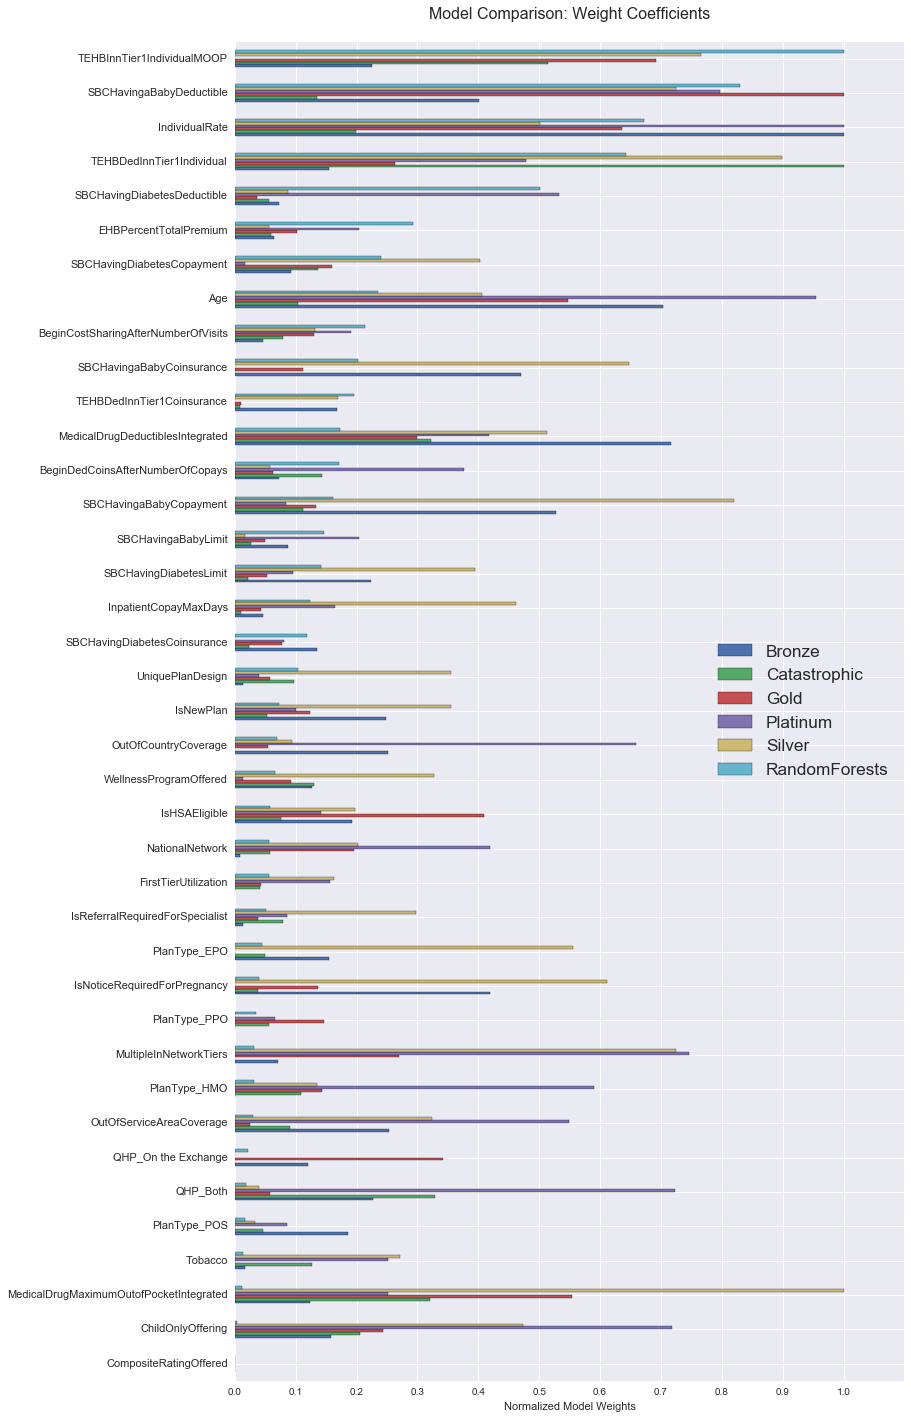

In [97]:
SGDweights = allWeights
weightsRF = pd.Series(gsrf_model.feature_importances_,index=colX)

allWeights = pd.concat([SGDweights,weightsRF],axis=1)
allWeights = allWeights.rename(columns={0:'RandomForests'})

allWeights['RandomForests'] = allWeights.RandomForests/allWeights.RandomForests.max()

plt.figure(figsize=(14,50))
allWeights.sort_values('RandomForests', ascending=True).plot(kind='barh',stacked=False,figsize=(12,24))
plt.xlim([0,1.1])
plt.xticks(np.arange(0, 1.05, .1))
plt.yticks(fontsize=11)
plt.title('Model Comparison: Weight Coefficients\n', fontsize = 16)
plt.xlabel('Normalized Model Weights')
plt.legend(loc='best', fontsize = 'x-large')
plt.show()

Insurance companies may want to use these models to gain some insight into how their plans are perceived by customers. Customers often rely on Metal Levels to make decisions about plans and it could prove profitable to offer customers more insight into the main components that make up the plan and how it contributes to the Metal Level. One way to test this is to setup an A/B test where customer have more information based on these models while another group of customers do not. 